In [41]:
# %reload_ext autoreload

In [42]:
%load_ext autoreload
%autoreload 1

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import geopandas as gpd

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score


from trampact.preprocess import get_data, drop_tx_columns, drop_non_tx_columns
from trampact.plot import draw_hist

In [44]:
# Only run once 
%aimport trampact.preprocess
%aimport trampact.plot
%matplotlib inline

In [45]:
!pwd

/home/primitive/code/eangelid/trampact/notebooks


In [46]:
IRIS_T1_CSV = 'iris_T1.csv'
IRIS_T2_CSV = 'iris_T2.csv'
BD_GENT_2006 = 'BD_GENT_2006.csv'
BD_GENT_2016 = 'BD_GENT_2016.csv'

# Load some dataframes
Attn: The `get_data()` method automatically sets `iris_id` as the index
#### Load geographic data

In [47]:
iris_france_filename = "../raw_data/iris_geo/iris-geo-2018-frtot.zip"

iris_france = gpd.read_file(iris_france_filename) # geopandas.dataframe

iris_france.drop(columns=['INSEE_COM','IRIS','NOM_IRIS'],inplace=True)
# gdf.drop(columns=['INSEE_COM','NOM_COM','IRIS','NOM_IRIS'],inplace=True)

In [150]:
iris_nice = iris_france[iris_france['NOM_COM'] == 'Nice'].rename(columns={'CODE_IRIS':'iris_id'}).reset_index().set_index(keys=['iris_id']).drop(columns=['index'])

#### Load T1 and T2 IRIS codes

In [49]:
iris_T1 = get_data(IRIS_T1_CSV, is_local_csv=True)

In [50]:
iris_T2__full = get_data(IRIS_T2_CSV, is_local_csv=True)

In [51]:
# drop other columns - only keep index (iris_id) and IRIS label (name)
iris_T2 = pd.DataFrame(iris_T2__full['NOM_IRIS'])

#### Load census (demographic) data
##### Alpes-Maritimes

In [52]:
census_2006_alpesmaritimes = get_data(BD_GENT_2006, is_local_csv=True)

In [53]:
census_2016_alpesmaritimes = get_data(BD_GENT_2016, is_local_csv=True)

<hr>

## Imputing
Do it here before creating new dataframes
#### Take a look at NULL values
Low percentage. We can get away with median (?)

In [54]:
census_2006_alpesmaritimes.isnull().sum().sort_values(ascending=False) #NaN count for each column
census_2006_alpesmaritimes.isnull().sum().sort_values(ascending=False)/len(census_2006_alpesmaritimes) #NaN percentage for each column

rev_2006                0.048
actifs_2006             0.000
tx_voit_2006            0.000
tx_chom_2006            0.000
tx_empl_2006            0.000
tx_ouvr_2006            0.000
tx_TP_2006              0.000
tx_HLM_2006             0.000
tx_no_transp_2006       0.000
tx_walk_2006            0.000
tx_moto_2006            0.000
tx_TC_2006              0.000
HH_2voit_2006           0.000
tx_HH_moins2ans_2006    0.000
tx_HH_2_4ans_2006       0.000
tx_HH_5_9ans_2006       0.000
tx_HH_plus10ans_2006    0.000
tx_HH_with_park_2006    0.000
tx_HH_with_voit_2006    0.000
tx_HH_1voit_2006        0.000
tx_HH_2voit_2006        0.000
pop_2006                0.000
HH_1voit_2006           0.000
chom_2006               0.000
walk_2006               0.000
empl_2006               0.000
ouvrier_2006            0.000
TP_2006                 0.000
Int_2006                0.000
app_stage_2006          0.000
cdd_2006                0.000
HLM_2006                0.000
no_transp_2006          0.000
moto_2006 

In [55]:
census_2016_alpesmaritimes.isnull().sum().sort_values(ascending=False) #NaN count for each column
census_2016_alpesmaritimes.isnull().sum().sort_values(ascending=False)/len(census_2016_alpesmaritimes) #NaN percentage for each column

rev_2016                0.054
tx_empl_prec_2016       0.002
tx_voit_2016            0.002
tx_chom_2016            0.002
tx_empl_2016            0.002
tx_ouvr_2016            0.002
tx_TP_2016              0.002
tx_HLM_2016             0.002
tx_no_transp_2016       0.002
tx_walk_2016            0.002
tx_moto_2016            0.002
tx_TC_2016              0.002
tx_HH_moins2ans_2016    0.002
tx_HH_2_4ans_2016       0.002
tx_HH_5_9ans_2016       0.002
tx_HH_plus10ans_2016    0.002
tx_HH_with_park_2016    0.002
tx_HH_with_voit_2016    0.002
tx_HH_1voit_2016        0.002
tx_HH_2voit_2016        0.002
HH_2voit_2016           0.000
pop_2016                0.000
actifs_2016             0.000
chom_2016               0.000
walk_2016               0.000
empl_2016               0.000
ouvrier_2016            0.000
TP_2016                 0.000
Int_2016                0.000
app_stage_2016          0.000
cdd_2016                0.000
HLM_2016                0.000
no_transp_2016          0.000
moto_2016 

In [56]:
rev_2006_mean_before = census_2006_alpesmaritimes['rev_2006'].mean()

simp_imputer = SimpleImputer(strategy="mean")
simp_imputer.fit(census_2006_alpesmaritimes[['rev_2006']])

census_2006_alpesmaritimes['rev_2006'] = simp_imputer.transform(census_2006_alpesmaritimes[['rev_2006']])

print(f'rev_2006 - mean: Before {rev_2006_mean_before} , After{simp_imputer.statistics_[0]}') 

rev_2006 - mean: Before 17310.4737394958 , After17310.4737394958


In [57]:
rev_2016_mean_before = census_2016_alpesmaritimes['rev_2016'].mean()

simp_imputer = SimpleImputer(strategy="mean")
simp_imputer.fit(census_2016_alpesmaritimes[['rev_2016']])

census_2016_alpesmaritimes['rev_2016'] = simp_imputer.transform(census_2016_alpesmaritimes[['rev_2016']])

print(f'rev_2016 - mean: Before {rev_2016_mean_before} , After{simp_imputer.statistics_[0]}') 

rev_2016 - mean: Before 21324.373848523497 , After21324.373848523497


# Some more dataframes
#### Merge dataframes to get Nice quarters ONLY

In [154]:
census_2006_nice = census_2006_alpesmaritimes.join(iris_nice, how='inner').drop(columns=['NOM_COM', 'TYP_IRIS', 'geometry'])

In [155]:
census_2016_nice = census_2016_alpesmaritimes.join(iris_nice, how='inner').drop(columns=['NOM_COM', 'TYP_IRIS', 'geometry'])

#### Merge dataframes to get T1 quarters ONLY

In [157]:
# bd_gent_2006_T1 = bd_gent_2006.merge(iris_T1, on='iris_id').drop('NOM_IRIS', axis=1)
census_2006_T1 = census_2006_nice.join(iris_T1, how='inner').drop('NOM_IRIS', axis=1)

In [158]:
census_2016_T1 = census_2016_nice.join(iris_T1, how='inner').drop('NOM_IRIS', axis=1)

#### Drop columns with ratios - We do not always need them

In [159]:
census_2006_nice_no_tx = drop_tx_columns(census_2006_nice, '2006')

In [160]:
census_2016_nice_no_tx = drop_tx_columns(census_2016_nice, '2016')

In [161]:
census_2006_T1_no_tx = drop_tx_columns(census_2006_T1, '2006')

In [162]:
census_2016_T1_no_tx = drop_tx_columns(census_2016_T1, '2016')

#### Keep columns with ratios - We sometimes need them

In [163]:
census_2006_nice_tx = drop_non_tx_columns(census_2006_nice, '2006')

In [164]:
census_2016_nice_tx = drop_non_tx_columns(census_2016_nice, '2016')

In [165]:
census_2006_T1_tx = drop_non_tx_columns(census_2006_T1, '2006')

In [166]:
census_2016_T1_tx = drop_non_tx_columns(census_2016_T1, '2016')

In [167]:
dataframes = {
    'census_2006_alpesmaritimes': census_2006_alpesmaritimes,
    'census_2016_alpesmaritimes': census_2016_alpesmaritimes,


    'census_2006_nice': census_2006_nice,
    'census_2016_nice': census_2016_nice,

    'census_2006_T1': census_2006_T1,
    'census_2016_T1': census_2016_T1,


    'census_2006_nice_tx': census_2006_nice_tx,
    'census_2016_nice_tx': census_2016_nice_tx,

    'census_2006_T1_tx': census_2006_T1_tx,
    'census_2016_T1_tx': census_2016_T1_tx,


    'census_2006_nice_no_tx': census_2006_nice_no_tx,
    'census_2016_nice_no_tx': census_2016_nice_no_tx,

    'census_2006_T1_no_tx': census_2006_T1_no_tx,
    'census_2016_T1_no_tx': census_2016_T1_no_tx
}

<hr>

<hr>

## Check dataframes
🚨(no need to run this part if not the first time loading the data frames)🚨

In [168]:
iris_T1.head()

,NOM_IRIS
iris_id,
060881304,Saint-Sylvestre
060881503,Jeanne d'Arc-Fuon-Cauda
060881303,Gorbella
060881505,Michelet
060881302,Saint-Barthelemy


In [169]:
iris_T2.head()

,NOM_IRIS
iris_id,
061230107,Centre Ville
061230103,Les Pomarels
061230102,Les Paluds
061230101,Le Lac
060883102,Parc des Sports


In [170]:
for dataframe in dataframes.keys():
    print(f"Shape '{dataframe}': \t\t" + str(dataframes[dataframe].shape))


Shape 'census_2006_alpesmaritimes': 		(500, 44)
Shape 'census_2016_alpesmaritimes': 		(500, 44)
Shape 'census_2006_nice': 		(146, 44)
Shape 'census_2016_nice': 		(146, 44)
Shape 'census_2006_T1': 		(35, 44)
Shape 'census_2016_T1': 		(35, 44)
Shape 'census_2006_nice_tx': 		(146, 19)
Shape 'census_2016_nice_tx': 		(146, 19)
Shape 'census_2006_T1_tx': 		(35, 19)
Shape 'census_2016_T1_tx': 		(35, 19)
Shape 'census_2006_nice_no_tx': 		(146, 25)
Shape 'census_2016_nice_no_tx': 		(146, 25)
Shape 'census_2006_T1_no_tx': 		(35, 25)
Shape 'census_2016_T1_no_tx': 		(35, 25)


<hr>

## Draw histograms - compare 2006 to 2016 and Nice vs. T1/T2

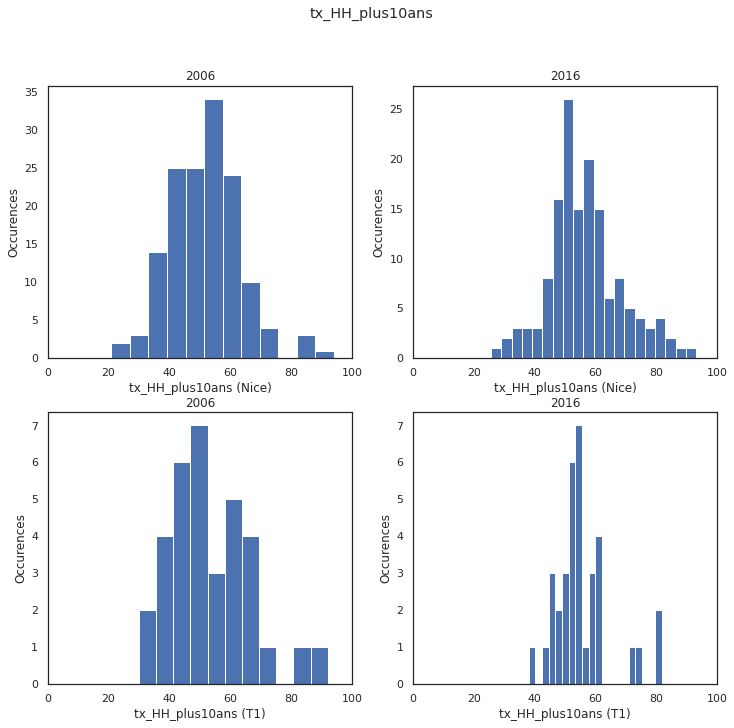

In [171]:
feature_label = 'tx_HH_plus10ans'
draw_hist(census_2006_nice_tx, census_2016_nice_tx, census_2006_T1_tx, census_2016_T1_tx, feature_label, bins=20)

<hr>

<hr>

In [219]:
year = '2016'
area = 'nice' # valid values are alpesmaritimes/nice/T1/T1
tx = 'tx' # or no_tx

df_name = f'census_{year}'
if len(area) > 0:
    df_name = df_name + '_' + area

df_name = df_name + '_' + tx
df_name

'census_2016_nice_tx'

In [220]:
working_df = dataframes[df_name]

## Pearson correlation 🚀

In [221]:
corr = working_df.corr()

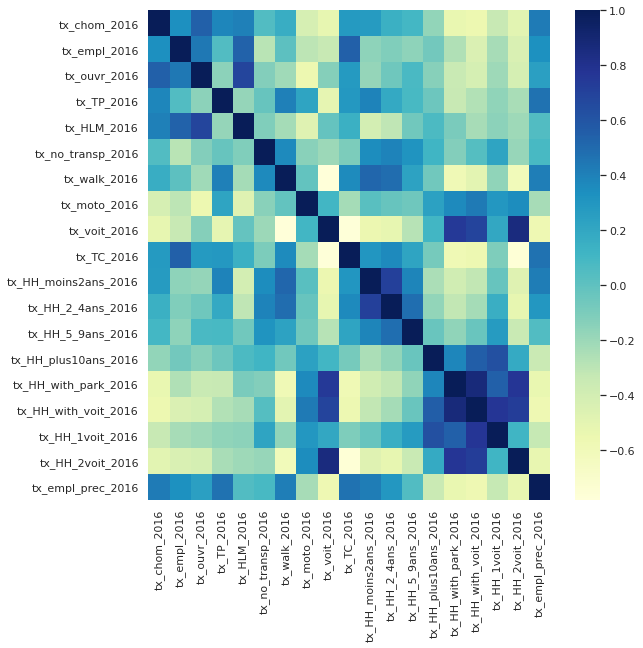

In [222]:
fig, ax = plt.subplots(figsize=(9,9))
ax = sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns,
        cmap= "YlGnBu")

In [223]:
corr_df = corr.unstack().reset_index() # Unstack correlation matrix 
corr_df.columns = ['feature_1','feature_2', 'correlation'] # rename columns
corr_df.sort_values(by="correlation",ascending=False, inplace=True) # sort by correlation
corr_df = corr_df[corr_df['feature_1'] != corr_df['feature_2']] # Remove self correlation
corr_df.reset_index(inplace=True, drop=True)

In [224]:
max = corr_df.shape[0]
indices = []
for i in range(0,max):
    if i%2==0:
        indices.append(i)
corr_df.iloc[indices]

,feature_1,feature_2,correlation
0,tx_HH_with_voit_2016,tx_HH_with_park_2016,0.868601
2,tx_voit_2016,tx_HH_2voit_2016,0.858968
4,tx_HH_1voit_2016,tx_HH_with_voit_2016,0.769313
6,tx_HH_2voit_2016,tx_HH_with_park_2016,0.764564
8,tx_voit_2016,tx_HH_with_park_2016,0.744879
...,...,...,...
332,tx_HH_with_park_2016,tx_walk_2016,-0.584809
334,tx_HH_2voit_2016,tx_walk_2016,-0.602812
336,tx_TC_2016,tx_HH_2voit_2016,-0.763492
338,tx_TC_2016,tx_voit_2016,-0.769174


## Pairplots

In [225]:
df_name

'census_2016_nice_tx'

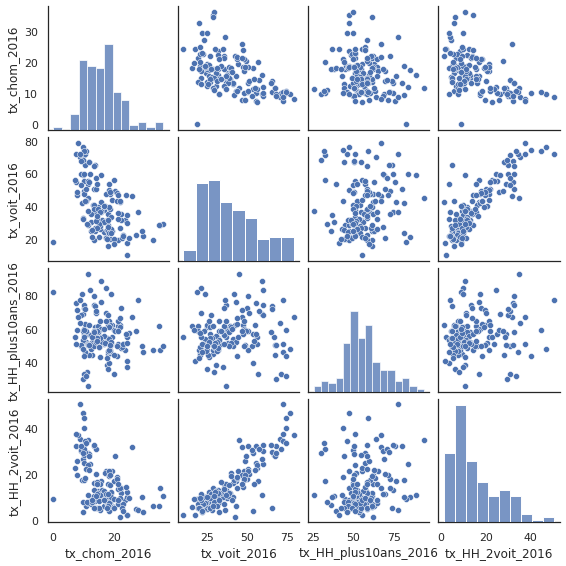

In [226]:
feature_list = np.array(['chom', 'voit', 'HH_plus10ans', 'HH_2voit'])
if tx == 'tx':
    feature_list = [('tx_' + _) for _ in feature_list]
feature_list = [(_ + '_' + year) for _ in feature_list]

sns.set(style='white')
sns.pairplot(working_df[feature_list], height=2)

plt.show()

## Time for a bit of modelling

### Model parameters - Chage these to dig into e.g. Nice or just T1 or 2006 vs 2016


In [227]:
df_name

'census_2016_nice_tx'

In [228]:
df__X = working_df

In [229]:
scaler = StandardScaler()
df__X__scaled = pd.DataFrame(scaler.fit_transform(df__X))

In [230]:
pca = PCA()

In [231]:
pca.fit(df__X__scaled)

PCA()

In [232]:
Wt = pd.DataFrame(pca.components_)

In [233]:
Wt

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,-2.496357e-01,-1.673863e-01,-1.515190e-01,-1.697477e-01,-6.754128e-02,-5.707415e-02,-2.458857e-01,1.564234e-01,3.435695e-01,-2.811584e-01,-2.107933e-01,-1.900599e-01,-1.031529e-01,1.500188e-01,3.384776e-01,0.341228,0.172182,0.344148,-2.743412e-01
1,1.545424e-01,3.044693e-01,3.604918e-01,-1.633823e-01,4.049842e-01,-2.513859e-01,-2.682921e-01,-2.616446e-01,1.361384e-01,1.603916e-02,-3.370955e-01,-3.236379e-01,-2.174439e-01,-7.658750e-02,-2.351615e-02,-0.136350,-0.221068,0.027443,-6.299761e-03
2,7.026759e-02,9.832104e-02,2.695983e-01,-2.219154e-01,2.888838e-01,2.575038e-01,-5.960730e-02,-1.879257e-01,-6.092074e-02,1.463501e-01,-4.087770e-02,1.616585e-01,3.450329e-01,3.922886e-01,9.841091e-02,0.200280,0.485859,-0.214884,-1.301223e-01
3,-4.887186e-02,3.413099e-01,-1.397685e-01,3.502520e-01,2.157876e-02,-3.609068e-01,7.067029e-02,3.832416e-01,-2.226208e-01,3.225587e-01,-1.375839e-01,-1.671033e-01,-2.009533e-01,3.982653e-01,7.360592e-02,0.088654,0.187682,-0.065452,6.387002e-02
4,-5.025594e-01,1.961261e-01,-4.241809e-02,-4.485170e-01,-1.834577e-01,-3.423290e-01,-7.386150e-02,3.252519e-02,2.516474e-02,3.728498e-01,-1.356956e-02,2.136280e-01,1.425613e-01,-3.035708e-01,8.106256e-03,-0.079048,0.032922,-0.158603,-1.346817e-01
5,-2.865812e-01,4.779494e-02,-2.258949e-01,-3.158308e-01,3.062196e-02,3.779077e-01,4.516299e-01,-1.435961e-01,-1.261171e-01,-1.573194e-02,-2.399181e-01,-1.707320e-01,-3.594333e-01,2.593915e-01,-1.740397e-01,-0.140422,-0.121722,-0.086516,-1.575408e-01
6,-7.847609e-02,2.901705e-01,-5.380040e-02,-7.659660e-02,-8.536511e-02,2.249342e-01,-1.411095e-01,-2.261064e-01,1.121633e-01,4.342488e-02,2.069588e-01,1.937017e-01,-4.809594e-01,-7.156667e-02,2.641675e-01,0.149846,0.179561,0.038511,5.610139e-01
7,-3.739977e-01,1.201972e-01,-1.008417e-01,2.080885e-01,1.892666e-01,2.249126e-01,1.238420e-01,3.922231e-03,6.093082e-02,7.844276e-04,-2.918684e-01,-2.943745e-01,5.132073e-01,-1.953666e-01,8.817634e-02,0.035104,-0.033902,0.091324,4.414129e-01
8,1.462966e-01,4.410837e-01,-1.198034e-01,-1.352066e-01,3.539209e-01,2.291003e-01,6.320160e-02,5.083209e-01,-8.325623e-02,-2.584535e-01,1.105881e-01,1.989475e-01,1.357309e-02,-2.487336e-01,2.492198e-01,-0.074964,-0.107524,-0.000097,-2.106979e-01
9,1.378926e-01,3.042737e-01,-5.025796e-01,1.968792e-01,2.332346e-03,-5.147616e-02,-2.278279e-03,-5.525468e-01,8.080398e-03,1.432437e-01,1.805767e-01,-4.148419e-02,1.807354e-01,1.443126e-02,1.937161e-01,0.029938,-0.119521,0.176046,-3.429299e-01


In [234]:
df__X__scaled_PCA = pd.DataFrame(pca.transform(df__X__scaled))

<AxesSubplot:>

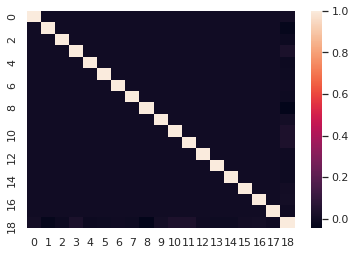

In [235]:
sns.heatmap(df__X__scaled_PCA.corr())

In [236]:
numpy__X__scaled_PCA = df__X__scaled_PCA.to_numpy(copy=True) # What was the problem? Wrong datatype expected=numpy, passed:pd.DataFrame

df = pd.DataFrame()
df["vif_index"] = [vif(numpy__X__scaled_PCA, i) for i in range(numpy__X__scaled_PCA.shape[1])]

In [237]:
df

,vif_index
0,1.000063
1,1.000919
2,1.000183
3,1.000897
4,1.000171
5,1.000067
6,1.000025
7,1.000062
8,1.002158
9,1.000048


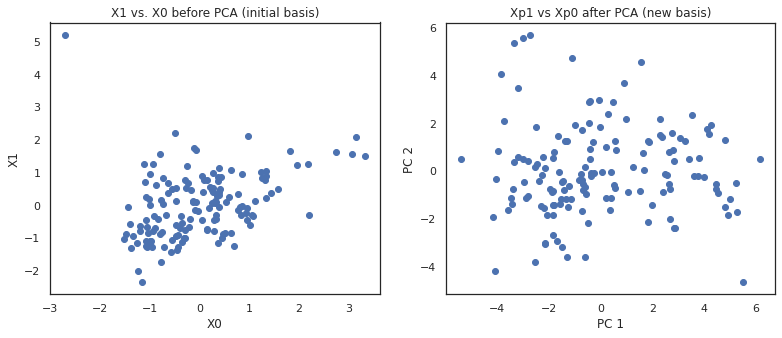

In [238]:
numpy__X__scaled = df__X__scaled.to_numpy()

plt.figure(figsize=(13,5))

plt.subplot(1,2,1)
plt.title('X1 vs. X0 before PCA (initial basis)'); plt.xlabel('X0'); plt.ylabel('X1')
plt.scatter(numpy__X__scaled[:,0], numpy__X__scaled[:,1])

plt.subplot(1,2,2)
plt.title('Xp1 vs Xp0 after PCA (new basis)'); plt.xlabel('PC 1'); plt.ylabel('PC 2')
plt.scatter(numpy__X__scaled_PCA[:,0], numpy__X__scaled_PCA[:,1])

In [239]:
#'Rank' PC per order of 'importance'
df_Xp = df__X__scaled_PCA # sample: pd.DataFrame(Xp)
df_Xp.std()**2 / ((df_Xp.std()**2).sum())

0     3.535449e-01
1     1.857668e-01
2     1.031664e-01
3     8.074919e-02
4     5.341187e-02
5     4.973596e-02
6     3.531925e-02
7     2.626267e-02
8     2.196449e-02
9     2.075128e-02
10    1.527650e-02
11    1.360158e-02
12    1.153288e-02
13    1.087638e-02
14    8.864890e-03
15    5.974828e-03
16    3.057368e-03
17    1.427366e-04
18    5.626873e-31
dtype: float64

In [240]:
pca.explained_variance_ratio_

array([3.53544888e-01, 1.85766806e-01, 1.03166443e-01, 8.07491860e-02,
       5.34118664e-02, 4.97359554e-02, 3.53192497e-02, 2.62626661e-02,
       2.19644859e-02, 2.07512786e-02, 1.52765050e-02, 1.36015846e-02,
       1.15328781e-02, 1.08763846e-02, 8.86489031e-03, 5.97482804e-03,
       3.05736773e-03, 1.42736578e-04, 5.72810837e-31])

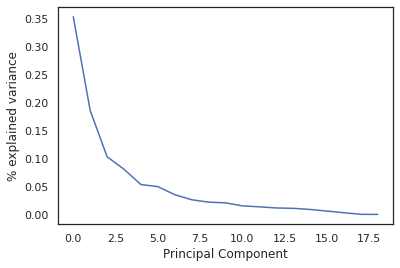

In [241]:
plt.plot(pca.explained_variance_ratio_)
plt.xlabel('Principal Component'); 
plt.ylabel('% explained variance');

In [242]:
eig_vals, eig_vecs = np.linalg.eig(np.dot(df__X__scaled.T,df__X__scaled))

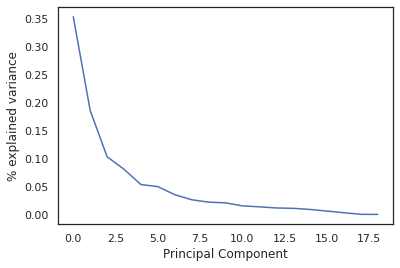

In [243]:
# Compute the share of explained variance per component
tot = sum(eig_vals)
share_of_variances = [(i / tot) for i in sorted(eig_vals, reverse=True)]
plt.plot(share_of_variances); 
plt.xlabel('Principal Component'); 
plt.ylabel('% explained variance');

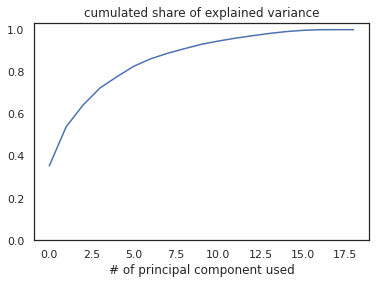

In [244]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.ylim(ymin=0)
plt.title('cumulated share of explained variance')
plt.xlabel('# of principal component used');

In [245]:
y_pred = df__X__scaled[18]

# model = LogisticRegression()
from sklearn.linear_model import LinearRegression
model = LinearRegression()

print("accuracy all features")
cross_val_score(model, df__X__scaled, y_pred, cv=10).mean()

accuracy all features


1.0

In [246]:
#
# !--- HERE!!!! Type the number of components that PCA found or you want to use ---!
#
n_components = 4

In [247]:
pca2 = PCA(n_components).fit(df__X__scaled)

# Print our 2 principal components
pd.DataFrame(pca2.components_)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,-0.249636,-0.167386,-0.151519,-0.169748,-0.067541,-0.057074,-0.245886,0.156423,0.343570,-0.281158,-0.210793,-0.190060,-0.103153,0.150019,0.338478,0.341228,0.172182,0.344148,-0.274341
1,0.154542,0.304469,0.360492,-0.163382,0.404984,-0.251386,-0.268292,-0.261645,0.136138,0.016039,-0.337095,-0.323638,-0.217444,-0.076587,-0.023516,-0.136350,-0.221068,0.027443,-0.006300
2,0.070268,0.098321,0.269598,-0.221915,0.288884,0.257504,-0.059607,-0.187926,-0.060921,0.146350,-0.040878,0.161659,0.345033,0.392289,0.098411,0.200280,0.485859,-0.214884,-0.130122
3,-0.048872,0.341310,-0.139769,0.350252,0.021579,-0.360907,0.070670,0.383242,-0.222621,0.322559,-0.137584,-0.167103,-0.200953,0.398265,0.073606,0.088654,0.187682,-0.065452,0.063870


In [248]:
X__pca__2 = pca2.fit_transform(df__X__scaled)

In [249]:
pd.DataFrame(X__pca__2)

,0,1,2,3
0,-1.671393,-2.931750,0.797947,1.757294
1,-4.025664,-0.343009,-2.119023,0.327968
2,-3.389941,-0.759889,-1.029336,0.562730
3,-1.878073,-0.878941,-1.014114,-0.303215
4,-0.480530,-2.213035,-0.008160,0.907169
...,...,...,...,...
141,4.259194,1.928177,-3.538551,-2.128574
142,3.518556,2.328010,-1.865879,-0.094841
143,4.123831,1.751749,-3.133900,-0.158022
144,4.818030,1.291930,-2.505757,-0.916162


In [250]:
print(f"accuracy {n_components} features")
cross_val_score(model, X__pca__2, y_pred, cv=10).mean()

accuracy 4 features


0.33496901874222984

In [251]:
# Keep only 1 dimension
pca1 = PCA(n_components=1)

X__pca__1 = pca1.fit_transform(df__X__scaled) # Reminder: df__X_scaled == bd_gent_20??_no_tx__scaled

pd.DataFrame(X__pca__1)
print("accuracy 1 features")
cross_val_score(model, X__pca__1, y_pred, cv=10).mean()

accuracy 1 features


0.41999962140472535

# KMeans

In [252]:
#
# !--- HERE!!!! Type the number of components you want to use ---!
#
n_clusters = 5
# n_clusters = n_components

In [253]:
km = KMeans(n_clusters)
km.fit(df__X__scaled_PCA)

KMeans(n_clusters=5)

In [254]:
km.cluster_centers_

array([[-3.51242699e+00,  3.26009468e+00, -1.99001477e-01,
         1.41071310e-01, -9.58490581e-01, -7.37139078e-01,
        -3.05675996e-01,  2.55622558e-01,  9.13099498e-02,
         8.59349025e-02,  7.04251162e-02,  1.19312232e-01,
        -2.10614514e-01, -5.21319463e-02,  2.65873658e-01,
        -2.31084032e-02, -3.64696713e-02,  5.15367520e-03,
        -7.49724232e-17],
       [ 3.44553882e+00, -2.20404909e-01, -4.59337194e-01,
        -2.50403846e-01, -9.83256464e-02, -4.44612484e-02,
        -1.27453071e-02, -3.15151392e-05,  1.65059400e-02,
         7.32362298e-02,  3.03830340e-02,  3.30697531e-02,
        -1.10492253e-02, -8.83136287e-04,  3.49050499e-02,
        -4.63585317e-04, -5.36235268e-04,  1.92891628e-03,
        -7.31454153e-17],
       [-2.08433967e+00, -1.26753107e+00, -3.10794861e-01,
        -1.14802732e-01, -8.06753133e-02,  2.97546014e-01,
        -8.76740026e-02, -5.33798818e-02,  1.25638585e-04,
         9.28491757e-03,  1.04137031e-02,  7.13633556e-04,
    

In [255]:
km.labels_

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 1, 1, 1, 1, 2, 2, 3, 3,
       3, 3, 3, 0, 0, 3, 3, 3, 3, 0, 0, 0, 3, 4, 4, 4, 4, 4, 1, 1, 1, 1,
       1, 2, 3, 1, 1, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 1, 1, 3, 3, 3, 2, 3,
       3, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 2, 2, 0, 2, 2, 3, 0, 2, 2,
       2, 2, 2, 2, 1, 1, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 3, 2, 1, 1, 1, 1, 3, 1, 1, 1, 1, 3, 0, 0, 3, 1, 1, 2, 3,
       3, 1, 1, 1, 1, 1, 1, 3, 3, 1, 1, 1, 1, 1], dtype=int32)

Text(0, 0.5, 'PC 2')

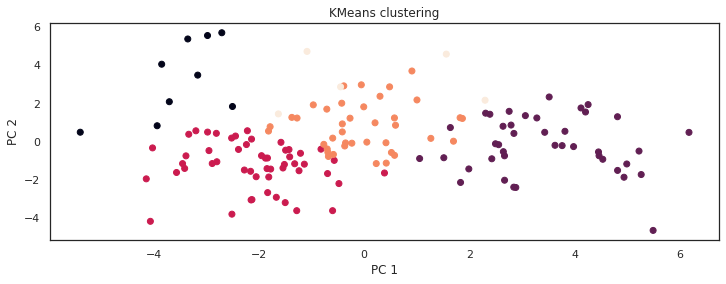

In [256]:
numpy__X__scaled_PCA = df__X__scaled_PCA.to_numpy()

plt.figure(figsize=(12,4))
plt.scatter(numpy__X__scaled_PCA[:,0], numpy__X__scaled_PCA[:,1], c=km.labels_)
plt.title('KMeans clustering'); 
plt.xlabel('PC 1');
plt.ylabel('PC 2')

Text(0.5, 1.0, 'True classification')

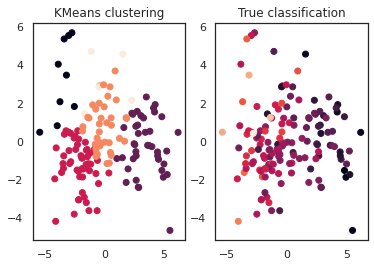

In [257]:
plt.subplot(1,2,1)
plt.scatter(numpy__X__scaled_PCA[:,0], numpy__X__scaled_PCA[:,1], c=km.labels_)
plt.title('KMeans clustering')

plt.subplot(1,2,2)
plt.scatter(numpy__X__scaled_PCA[:,0], numpy__X__scaled_PCA[:,1], c=y_pred)
plt.title('True classification')

In [258]:
# ?????
# km.predict(new_X)

Text(0.5, 0, 'k cluster number')

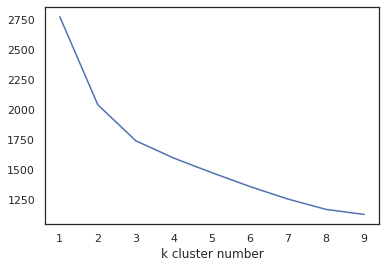

In [259]:
inertias = []
ks = range(1,10)
for k in ks:
    km_test = KMeans(n_clusters=k).fit(df__X__scaled_PCA)
    inertias.append(km_test.inertia_)
plt.plot(ks, inertias)
plt.xlabel('k cluster number')

In [260]:
df__X['pca_labels'] = km.labels_

In [261]:
# df_tmp = df__X[['pop_2006', 'pca_labels']]
df_tmp = df__X[['pca_labels']]
df_tmp.reset_index(inplace=True)

In [262]:
file_out = f'{df_name}_kmeans={n_clusters}.csv'
file_out

'census_2016_nice_tx_kmeans=5.csv'

In [263]:
df_tmp.to_csv(os.path.join('..', 'trampact', 'data', 'pca_kmeans_results', file_out), index=False)

In [264]:
df__X.drop(columns=['pca_labels'], inplace=True)